In [1]:
#Dependencies
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import datetime as dt
import numpy as np
from collections import Counter 

In [2]:
#Load Data
#Will be database connection, don't have that yet

In [65]:
#temporary
data=pd.read_csv("Resources/merged_AKC.csv")
data.head()

,Animal ID,Intake_Type,Intake_Condition,Breed,Color,Age_in_Years,Intactness,Sex,Age,Breed_Type,...,Breed_update,Breed1,Breed2,AKC_group1,Size1,AKC_group2,Size2,Sorted_Color,Restricted,Multiple_Intakes
0,A006100,Public Assist,Normal,Spinone Italiano Mix,Yellow/White,6.0,Altered,Male,Adult,Mix,...,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,0
1,A006100,Public Assist,Normal,Spinone Italiano Mix,Yellow/White,7.0,Altered,Male,Adult,Mix,...,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,1
2,A006100,Stray,Normal,Spinone Italiano Mix,Yellow/White,10.0,Altered,Male,Senior,Mix,...,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,1
3,A047759,Owner Surrender,Normal,Dachshund,Tricolor,10.0,Altered,Male,Senior,Pure,...,Dachshund,Dachshund,NaN,hound,small,NaN,NaN,Tricolor,No,0
4,A134067,Public Assist,Injured,Shetland Sheepdog,Brown/White,16.0,Altered,Male,Senior,Pure,...,Shetland Sheepdog,Shetland Sheepdog,NaN,herding,small,NaN,NaN,Brown/White,No,0


In [66]:
data["in_Month"]=data["in_Month"].astype(str)
nums=("1","2","3","4","5","6","7","8","9","10","11","12")
months=("Jan","Feb","Mar","Apr","May","June","July","Aug","Sep","Oct","Nov","Dec")
data["in_Month"]= data["in_Month"].replace(nums,months)


In [67]:
#Drop original columns not needed
data=data.drop(columns=["Animal ID","Breed", "Color", "Age_in_Years"])

In [68]:
#Drop rows where Outcome Type is missing or labeled "Missing", disposal and rto-adopt
data=data.dropna(subset=["Outcome_Type"])
data=data.drop(data[data["Outcome_Type"]=="Missing"].index)
data=data.drop(data[data["Outcome_Type"]=="Disposal"].index)
#data=data.drop(data[data["Outcome_Type"]=="Rto-Adopt"].index)

In [69]:
#rename columns
data=data.rename(columns={"Intake_Type": "Type", "Intake_Condition": "Cond",
                          "Outcome_Type":"Outcome", "Length_of_Stay":"LS", "in_Month":"m", "in_Year":"y",
                          "AKC_group1":"group1", "AKC_group2": "group2"})
data.head()

,Type,Cond,Intactness,Sex,Age,Breed_Type,Outcome,LS,m,y,Breed_update,Breed1,Breed2,group1,Size1,group2,Size2,Sorted_Color,Restricted,Multiple_Intakes
0,Public Assist,Normal,Altered,Male,Adult,Mix,Return to Owner,2,Mar,2014,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,0
1,Public Assist,Normal,Altered,Male,Adult,Mix,Return to Owner,2,Dec,2014,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,1
2,Stray,Normal,Altered,Male,Senior,Mix,Return to Owner,1,Dec,2017,Spinone Italiano,Spinone Italiano,NaN,sporting,large,NaN,NaN,Tan,No,1
3,Owner Surrender,Normal,Altered,Male,Senior,Pure,Transfer,6,Apr,2014,Dachshund,Dachshund,NaN,hound,small,NaN,NaN,Tricolor,No,0
4,Public Assist,Injured,Altered,Male,Senior,Pure,Return to Owner,1,Nov,2013,Shetland Sheepdog,Shetland Sheepdog,NaN,herding,small,NaN,NaN,Brown/White,No,0


In [70]:
print(data["LS"].describe())

count    75879.000000
mean        18.801526
std         48.284436
min          1.000000
25%          3.000000
50%          6.000000
75%         13.000000
max       1914.000000
Name: LS, dtype: float64


In [71]:
Counter(data["Outcome"])

Counter({'Return to Owner': 20165,
         'Transfer': 16533,
         'Adoption': 36373,
         'Euthanasia': 1853,
         'Died': 294,
         'Rto-Adopt': 661})

In [72]:
#drop bad outcomes to check LS metrics
good=data.drop(data[data["Outcome"]=="Euthanasia"].index)
good=good.drop(data[data["Outcome"]=="Died"].index)

good["LS"].describe()

count    73732.000000
mean        18.874356
std         48.170861
min          1.000000
25%          3.000000
50%          6.000000
75%         13.000000
max       1914.000000
Name: LS, dtype: float64

array([[<AxesSubplot:title={'center':'LS'}>]], dtype=object)

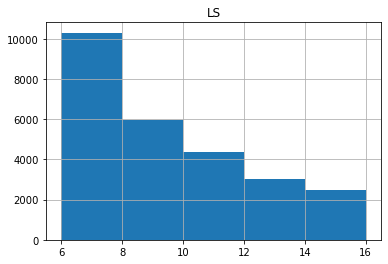

In [73]:
pd.DataFrame.hist(data=good,column="LS", bins=[6,8,10,12,14,16])


In [74]:
data["LS_75"]=np.where((data["LS"]<13),0,1)


In [75]:
data["LS_75"].value_counts()

0    56147
1    19732
Name: LS_75, dtype: int64

In [77]:
#Drop if Intactness=Unknown or missing
data=data.drop(data[data["Intactness"]=="Unknown"].index)
data=data.dropna(subset=["Intactness"])
#Recode binary variables to 0,1
codes=[0,1]
sex=["Male","Female"]
snip=["Intact","Altered"]
mix=["Pure","Mix"]
restrict=["No","Yes"]
prior=["No","Yes"]

data["snstatus"]=data["Intactness"].replace(snip, codes)
data["sex"]=data["Sex"].replace(sex,codes)
data["mix"]=data["Breed_Type"].replace(mix, codes)
data["restrict"]=data["Restricted"].replace(restrict, codes)
data["prior"]=data["Multiple_Intakes"].replace(prior, codes)
#Drop source columns
data=data.drop(columns=["Intactness", "Sex", "Breed_Type","Restricted","Multiple_Intakes"])



In [78]:
#group medical Cond
newcond=["med", "med", "med","norm","inj","aged","sick","other","preg","nurs","feral","behav","neonatal"]
cond=["Medical", "Med Urgent", "Med Attn", "Normal","Injured","Aged","Sick","Other","Pregnant","Nursing","Feral","Behavior","Neonatal"]
data["cond"]=data["Cond"].replace(cond, newcond)
Counter(data["cond"])

Counter({'norm': 68316,
         'inj': 3321,
         'aged': 386,
         'sick': 1872,
         'med': 110,
         'other': 133,
         'preg': 64,
         'nurs': 1097,
         'feral': 10,
         'behav': 39,
         'neonatal': 44})

In [79]:
newtypes=["assist", "stray", "surr", "Ereq", "aband"]
types=["Public Assist","Stray", "Owner Surrender", "Euthanasia Request", "Abandoned"]
data["type"]=data["Type"].replace(types, newtypes)
data=data.drop(columns=["Type"])
Counter(data["type"])

Counter({'assist': 6495,
         'stray': 52006,
         'surr': 16440,
         'Ereq': 176,
         'aband': 274,
         'Wildlife': 1})

In [80]:
data["LS_75"].value_counts()


0    55698
1    19694
Name: LS_75, dtype: int64

In [86]:
data["poor"]=np.where((data["Outcome"]=="Euthanasia")|(data["Outcome"]=="Died"),1,0)
data["outcome"]=np.where((data["poor"]==1)|(data["LS_75"])==1,1,0)
data["outcome"].value_counts()

                         
#coded_data["sporting"]=np.where((coded_data["group1_sporting"]==1)|(coded_data["group2_sporting"]==1), 1, 0) 


0    54138
1    21254
Name: outcome, dtype: int64

In [87]:
dummies=["type", "cond", "Age", "m", "group1", "group2", "Size1", "Size2","Sorted_Color"]
coded_data=pd.get_dummies(data[dummies])
coded_data["mix"]=data["mix"]
coded_data["sex"]=data["sex"]
coded_data["snstatus"]=data["snstatus"]
coded_data["restrict"]=data["restrict"]
coded_data["prior"]=data["prior"]

coded_data.head()

,type_Ereq,type_Wildlife,type_aband,type_assist,type_stray,type_surr,cond_aged,cond_behav,cond_feral,cond_inj,...,Sorted_Color_Red/White,Sorted_Color_Sable,Sorted_Color_Tan,Sorted_Color_Tricolor,Sorted_Color_White,mix,sex,snstatus,restrict,prior
0,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,1
2,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,1,0,1,0,1
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,0,0,0,1,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0


In [88]:
coded_data=coded_data.drop(columns=["type_Wildlife"])

In [89]:
coded_data.columns

Index(['type_Ereq', 'type_aband', 'type_assist', 'type_stray', 'type_surr',
       'cond_aged', 'cond_behav', 'cond_feral', 'cond_inj', 'cond_med',
       'cond_neonatal', 'cond_norm', 'cond_nurs', 'cond_other', 'cond_preg',
       'cond_sick', 'Age_Adult', 'Age_Puppy', 'Age_Senior', 'Age_Young',
       'm_Apr', 'm_Aug', 'm_Dec', 'm_Feb', 'm_Jan', 'm_July', 'm_June',
       'm_Mar', 'm_May', 'm_Nov', 'm_Oct', 'm_Sep', 'group1_cur',
       'group1_herding', 'group1_hound', 'group1_misc', 'group1_non-sporting',
       'group1_non-working', 'group1_pit bull', 'group1_sporting',
       'group1_terrier', 'group1_toy', 'group1_working', 'group2_cur',
       'group2_herding', 'group2_hound', 'group2_misc', 'group2_non-sporting',
       'group2_pit bull', 'group2_sporting', 'group2_terrier', 'group2_toy',
       'group2_working', 'Size1_large', 'Size1_medium', 'Size1_small',
       'Size2_large', 'Size2_medium', 'Size2_small', 'Sorted_Color_Black',
       'Sorted_Color_Black/Brown', 'Sorted_Co

In [90]:
#combine group1 and group2. Single variable, 1 if either group1 or group2.
coded_data["sporting"]=np.where((coded_data["group1_sporting"]==1)|(coded_data["group2_sporting"]==1), 1, 0) 
coded_data["working"]=np.where((coded_data["group1_working"]==1)|(coded_data["group2_working"]==1), 1, 0) 
coded_data["non-sporting"]=np.where((coded_data["group1_non-sporting"]==1)|(coded_data["group2_non-sporting"]==1), 1, 0) 
coded_data["hound"]=np.where((coded_data["group1_hound"]==1)|(coded_data["group2_hound"]==1), 1, 0) 
coded_data["herding"]=np.where((coded_data["group1_herding"]==1)|(coded_data["group2_herding"]==1), 1, 0) 
coded_data["toy"]=np.where((coded_data["group1_toy"]==1)|(coded_data["group2_toy"]==1), 1, 0) 
coded_data["terrier"]=np.where((coded_data["group1_terrier"]==1)|(coded_data["group2_terrier"]==1), 1, 0) 
coded_data["pit bull"]=np.where((coded_data["group1_pit bull"]==1)|(coded_data["group2_pit bull"]==1), 1, 0) 
coded_data["cur"]=np.where((coded_data["group1_cur"]==1)|(coded_data["group2_cur"]==1), 1, 0) 
coded_data["non-working"]=np.where((coded_data["group1_non-working"]==1), 1, 0) 
coded_data["g_misc"]=np.where((coded_data["group1_misc"]==1)|(coded_data["group2_misc"]==1), 1, 0) 


#Drop all the unnecessary columns
coded_data=coded_data.drop(columns=["group1_sporting","group2_sporting","group1_working","group2_working",
                        "group1_non-sporting","group2_non-sporting","group1_hound","group2_hound",
                        "group1_herding","group2_herding","group1_toy","group2_toy","group1_terrier",
                        "group2_terrier","group1_pit bull","group2_pit bull","group1_cur","group2_cur",
                        "group1_non-working","group1_misc","group2_misc"])

coded_data.head()

,type_Ereq,type_aband,type_assist,type_stray,type_surr,cond_aged,cond_behav,cond_feral,cond_inj,cond_med,...,working,non-sporting,hound,herding,toy,terrier,pit bull,cur,non-working,g_misc
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0


In [91]:
#combine group1 and group2. Single variable, 1 if either group1 or group2.
coded_data["small"]=np.where((coded_data["Size1_small"]==1)|(coded_data["Size2_small"]==1), 1, 0) 
coded_data["med"]=np.where((coded_data["Size1_medium"]==1)|(coded_data["Size2_medium"]==1), 1, 0) 
coded_data["large"]=np.where((coded_data["Size1_large"]==1)|(coded_data["Size2_large"]==1), 1, 0) 

#Drop all the unnecessary columns
coded_data=coded_data.drop(columns=["Size1_small","Size2_small","Size1_medium","Size2_medium","Size1_large","Size2_large"])

coded_data.columns

Index(['type_Ereq', 'type_aband', 'type_assist', 'type_stray', 'type_surr',
       'cond_aged', 'cond_behav', 'cond_feral', 'cond_inj', 'cond_med',
       'cond_neonatal', 'cond_norm', 'cond_nurs', 'cond_other', 'cond_preg',
       'cond_sick', 'Age_Adult', 'Age_Puppy', 'Age_Senior', 'Age_Young',
       'm_Apr', 'm_Aug', 'm_Dec', 'm_Feb', 'm_Jan', 'm_July', 'm_June',
       'm_Mar', 'm_May', 'm_Nov', 'm_Oct', 'm_Sep', 'Sorted_Color_Black',
       'Sorted_Color_Black/Brown', 'Sorted_Color_Black/Tan',
       'Sorted_Color_Black/White', 'Sorted_Color_Brindle',
       'Sorted_Color_Brown', 'Sorted_Color_Brown/Tan',
       'Sorted_Color_Brown/White', 'Sorted_Color_Gray',
       'Sorted_Color_Gray/White', 'Sorted_Color_Merle', 'Sorted_Color_Red',
       'Sorted_Color_Red/White', 'Sorted_Color_Sable', 'Sorted_Color_Tan',
       'Sorted_Color_Tricolor', 'Sorted_Color_White', 'mix', 'sex', 'snstatus',
       'restrict', 'prior', 'sporting', 'working', 'non-sporting', 'hound',
       'herding', 

In [24]:
#Factorize outcome
#factor=pd.factorize(data["Outcome"])
#data["outcome"]=factor[0]
#outcome_definitions=factor[1]
#outcome_definitions

Index(['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia', 'Died'], dtype='object')

In [92]:
#Define coded_data as feature set
X=coded_data.copy()
y=data["outcome"]


In [93]:
Counter(y)

Counter({0: 54138, 1: 21254})

In [94]:
#Split into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X,y,random_state=20)

In [95]:
#Check numbers for train v test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(56544, 68)
(18848, 68)
(56544,)
(18848,)


In [96]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=100, random_state=78)
#Fit classifier to training set
rf_model= rf_model.fit(X_train, y_train)
#Make prediction
predictions = rf_model.predict(X_test)
#Evaluate model
cm=confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index = ["Actual 0", "Actual 1"], 
                      columns=["Predicted 0", "Predicted 1"])
cm_df


,Predicted 0,Predicted 1
Actual 0,11732,1756
Actual 1,3461,1899


In [97]:
print(rf_model.score(X_train,y_train))
print(rf_model.score(X_test, y_test))
print(classification_report(y_test, predictions))

0.9192310413129599
0.7232067062818336
              precision    recall  f1-score   support

           0       0.77      0.87      0.82     13488
           1       0.52      0.35      0.42      5360

    accuracy                           0.72     18848
   macro avg       0.65      0.61      0.62     18848
weighted avg       0.70      0.72      0.71     18848



In [100]:
importances = rf_model.feature_importances_


In [101]:
feature_names=[coded_data.columns]
feature_names

[Index(['type_Ereq', 'type_aband', 'type_assist', 'type_stray', 'type_surr',
        'cond_aged', 'cond_behav', 'cond_feral', 'cond_inj', 'cond_med',
        'cond_neonatal', 'cond_norm', 'cond_nurs', 'cond_other', 'cond_preg',
        'cond_sick', 'Age_Adult', 'Age_Puppy', 'Age_Senior', 'Age_Young',
        'm_Apr', 'm_Aug', 'm_Dec', 'm_Feb', 'm_Jan', 'm_July', 'm_June',
        'm_Mar', 'm_May', 'm_Nov', 'm_Oct', 'm_Sep', 'mix', 'sex', 'snstatus',
        'restrict', 'prior', 'sporting', 'working', 'non-sporting', 'hound',
        'herding', 'toy', 'terrier', 'pit bull', 'cur', 'non-working', 'g_misc',
        'small', 'med', 'large'],
       dtype='object')]

In [103]:
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

/Users/annawiste/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  if __name__ == '__main__':


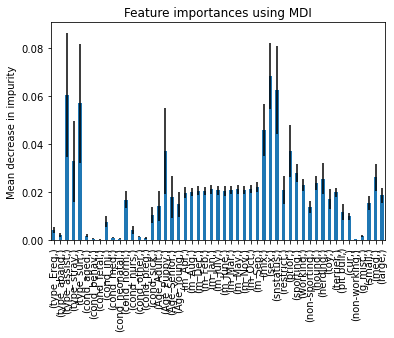

In [106]:
forest_importances = pd.Series(importances, index=feature_names)
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.show()


In [98]:
from sklearn.ensemble import GradientBoostingClassifier

# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier = GradientBoostingClassifier(n_estimators=100,
                                            learning_rate=learning_rate,
                                            max_features=10,
                                            max_depth=4,
                                            random_state=0)

    # Fit the model
    classifier.fit(X_train, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier.score(
            X_train,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier.score(
            X_test,
            y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.745
Accuracy score (validation): 0.740

Learning rate:  0.1
Accuracy score (training): 0.749
Accuracy score (validation): 0.743

Learning rate:  0.25
Accuracy score (training): 0.754
Accuracy score (validation): 0.745

Learning rate:  0.5
Accuracy score (training): 0.759
Accuracy score (validation): 0.745

Learning rate:  0.75
Accuracy score (training): 0.760
Accuracy score (validation): 0.744

Learning rate:  1
Accuracy score (training): 0.761
Accuracy score (validation): 0.743



In [99]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=100,
                                        learning_rate=0.3,
                                        max_features=10,
                                        max_depth=4,
                                        random_state=0)

# Fit the model
classifier.fit(X_train, y_train)

# Make Prediction
predictions = classifier.predict(X_test)

In [100]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    classifier.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    classifier.score(X_test,y_test)))
print(classification_report(y_test, predictions))

Accuracy score (training): 0.756
Accuracy score (validation): 0.745
              precision    recall  f1-score   support

           0       0.76      0.93      0.84     13488
           1       0.62      0.27      0.37      5360

    accuracy                           0.74     18848
   macro avg       0.69      0.60      0.61     18848
weighted avg       0.72      0.74      0.71     18848



In [102]:
cm1=confusion_matrix(y_test, predictions)
cm1_df = pd.DataFrame(cm1, index = ["Actual 0", "Actual 1"], 
                      columns=["Predicted 0", "Predicted 1"])
cm1_df

,Predicted 0,Predicted 1
Actual 0,12594,894
Actual 1,3919,1441


In [95]:
y_test.value_counts()

Adoption           9085
Return to Owner    5016
Transfer           4048
Euthanasia          481
Died                 53
Name: Outcome, dtype: int64

In [107]:
#check for good number of components
#components=[5,10,15,20]
#for component in components:
#    pca=PCA(n_components=components)
#    X_pca=pca.fit_transform(X)
#    print(pca.explained_variance_ratio_.sum())
    

In [116]:
#Initialize PCA
pca=PCA(n_components=20)

In [46]:
#pca=PCA(n_components=16)

In [117]:
#Apply to X
X_pca=pca.fit_transform(X)

In [118]:
pca.explained_variance_ratio_

array([0.11354398, 0.08549861, 0.07845401, 0.05907583, 0.0431889 ,
       0.03777943, 0.03264141, 0.02800741, 0.02728296, 0.0239452 ,
       0.02287856, 0.02179275, 0.02027596, 0.01990543, 0.01911411,
       0.01795387, 0.01669897, 0.01618091, 0.01577117, 0.01553397])

In [119]:
pca.explained_variance_ratio_.sum()

0.7155234384318053

In [120]:
#Create dataframe from pcas
X_pca_df=pd.DataFrame(data=X_pca, columns=["PC1","PC2","PC3","PC4","PC5","PC6","PC7","PC8","PC9",
                     "PC10","PC11","PC12","PC13","PC14","PC15","PC16","PC17","PC18","PC19","PC20"])
X_pca_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
0,0.271103,0.485910,0.811047,-0.024704,-0.516450,-0.622967,-0.588601,0.630313,0.741646,-0.766255,-0.199413,0.035135,0.259106,-0.655106,0.406780,0.585649,0.375719,-0.177815,0.135260,0.652799
1,0.346465,0.603172,1.051774,0.050429,-0.550851,-0.770268,-0.621487,0.259112,0.696889,-0.523991,-0.236331,-0.023280,0.197221,-0.733328,0.210105,0.280130,0.734731,-0.195649,0.063419,0.735007
2,0.241861,0.256545,0.488487,-0.381559,-0.483894,-0.920326,-0.613023,-0.562871,0.650616,0.133342,-0.457681,0.598328,-0.183545,-0.266321,-0.031068,0.611607,-0.182721,-0.336683,-0.101938,0.541426
3,-0.754141,0.978184,0.764153,0.510999,-0.450384,-0.009241,0.327556,0.305699,-0.124994,0.666956,0.196081,0.466012,0.596452,0.244387,-0.118678,1.080513,-0.493654,0.083751,-0.392241,-0.314926
4,-0.531269,0.796232,0.471942,0.045386,-0.439548,-0.196220,0.837077,0.736288,0.009500,0.516660,0.041905,1.357731,0.577157,0.458001,0.940912,-0.160542,-0.023217,0.300332,-0.597427,0.630812


In [121]:
#Split into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X_pca_df,y,random_state=20)

In [123]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=100, random_state=78)
#Fit classifier to training set
rf_model= rf_model.fit(X_train, y_train)
#Make prediction
predictions2 = rf_model.predict(X_test)
#Evaluate model
cm2=confusion_matrix(y_test, predictions2)
cm2_df = pd.DataFrame(cm2, index = ["Actual 0", "Actual 1"], 
                      columns=["Predicted 0", "Predicted 1"])
cm2_df

,Predicted 0,Predicted 1
Actual 0,11683,1805
Actual 1,3561,1799


In [124]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    rf_model.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    rf_model.score(X_test,y_test)))

Accuracy score (training): 0.919
Accuracy score (validation): 0.715


In [116]:
# Choose a learning rate and create classifier
classifier = GradientBoostingClassifier(n_estimators=100,
                                        learning_rate=0.2,
                                        max_features=10,
                                        max_depth=4,
                                        random_state=0)

# Fit the model
classifier.fit(X_train, y_train)

# Make Prediction
predictions = classifier.predict(X_test)

In [120]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    classifier.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    classifier.score(X_test,y_test)))
print(classification_report(y_test, predictions))

Accuracy score (training): 0.641
Accuracy score (validation): 0.604
                 precision    recall  f1-score   support

       Adoption       0.61      0.83      0.70      9085
           Died       0.05      0.06      0.06        53
     Euthanasia       0.26      0.06      0.10       481
Return to Owner       0.62      0.65      0.64      5016
       Transfer       0.49      0.11      0.18      4048

       accuracy                           0.60     18683
      macro avg       0.41      0.34      0.34     18683
   weighted avg       0.58      0.60      0.56     18683



In [119]:
cm=confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index = ["Actual 0", "Actual 1","Actual 2","Actual 3","Actual 4"], 
                      columns=["Predicted 0", "Predicted 1","Predicted 2","Predicted 3", "Predicted 4"])
cm_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3,Predicted 4
Actual 0,7517,16,29,1229,294
Actual 1,35,3,2,5,8
Actual 2,239,3,31,126,82
Actual 3,1610,17,17,3276,96
Actual 4,2866,16,40,666,460


# Test with lumping adopt and transfer

In [121]:
old=['Return to Owner', 'Transfer', 'Adoption', 'Euthanasia', 'Died']
new=['rto','adopted','adopted','euth','died']
data["newOut"]=data["Outcome"].replace(old,new)

In [64]:
#Factorize outcome
#factor=pd.factorize(data["newOut"])
#data["outcome"]=factor[0]
#outcome_definitions=factor[1]
#outcome_definitions

Index(['rto', 'adopted', 'euth', 'died'], dtype='object')

In [122]:

y=data["newOut"]
Counter(y)

Counter({'rto': 20079, 'adopted': 52582, 'euth': 1807, 'died': 263})

In [123]:
#Split into training and testing sets
X_train, X_test, y_train, y_test=train_test_split(X_pca_df,y,random_state=20)

In [124]:
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier(n_estimators=100, random_state=78)
#Fit classifier to training set
rf_model= rf_model.fit(X_train, y_train)
#Make prediction
predictions2 = rf_model.predict(X_test)
#Evaluate model
cm2=confusion_matrix(y_test, predictions2)
cm2_df = pd.DataFrame(cm2, index = ["Actual 0", "Actual 1","Actual 2","Actual 3"], 
                      columns=["Predicted 0", "Predicted 1","Predicted 2","Predicted 3"])
cm2_df

,Predicted 0,Predicted 1,Predicted 2,Predicted 3
Actual 0,11560,8,66,1499
Actual 1,44,2,1,6
Actual 2,333,4,32,112
Actual 3,2316,2,33,2665


In [125]:
# Score the model
print("Accuracy score (training): {0:.3f}".format(
    rf_model.score(X_train,y_train)))
print("Accuracy score (validation): {0:.3f}".format(
    rf_model.score(X_test,y_test)))
print(classification_report(y_test, predictions))

Accuracy score (training): 0.872
Accuracy score (validation): 0.763


/Users/annawiste/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawiste/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawiste/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_st

                 precision    recall  f1-score   support

       Adoption       0.00      0.00      0.00       0.0
           Died       0.00      0.00      0.00       0.0
     Euthanasia       0.00      0.00      0.00       0.0
Return to Owner       0.00      0.00      0.00       0.0
       Transfer       0.00      0.00      0.00       0.0
        adopted       0.00      0.00      0.00   13133.0
           died       0.00      0.00      0.00      53.0
           euth       0.00      0.00      0.00     481.0
            rto       0.00      0.00      0.00    5016.0

       accuracy                           0.00   18683.0
      macro avg       0.00      0.00      0.00   18683.0
   weighted avg       0.00      0.00      0.00   18683.0



/Users/annawiste/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/annawiste/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [69]:
coded_data.columns

Index(['type_Ereq', 'type_aband', 'type_assist', 'type_stray', 'type_surr',
       'cond_aged', 'cond_behav', 'cond_feral', 'cond_inj', 'cond_med',
       'cond_neonatal', 'cond_norm', 'cond_nurs', 'cond_other', 'cond_preg',
       'cond_sick', 'Age_Adult', 'Age_Puppy', 'Age_Senior', 'Age_Young',
       'm_Apr', 'm_Aug', 'm_Dec', 'm_Feb', 'm_Jan', 'm_July', 'm_June',
       'm_Mar', 'm_May', 'm_Nov', 'm_Oct', 'm_Sep', 'mix', 'sex', 'snstatus',
       'restrict', 'prior', 'sporting', 'working', 'non-sporting', 'hound',
       'herding', 'toy', 'terrier', 'pit bull', 'cur', 'non-working', 'g_misc',
       'small', 'med', 'large'],
      dtype='object')

In [70]:
y.value_counts()

adopted    52582
rto        20079
euth        1807
died         263
Name: newOut, dtype: int64

In [71]:
data["outcome"].value_counts()

1    52582
0    20079
2     1807
3      263
Name: outcome, dtype: int64

In [73]:
data.head()

,Cond,Age,Outcome,LS,m,y,Breed_update,Breed1,Breed2,group1,...,Sorted_Color,snstatus,sex,mix,restrict,prior,cond,type,outcome,newOut
0,Normal,Adult,Return to Owner,2,Mar,2014,Spinone Italiano,Spinone Italiano,NaN,sporting,...,Tan,1,0,1,0,0,norm,assist,0,rto
1,Normal,Adult,Return to Owner,2,Dec,2014,Spinone Italiano,Spinone Italiano,NaN,sporting,...,Tan,1,0,1,0,1,norm,assist,0,rto
2,Normal,Senior,Return to Owner,1,Dec,2017,Spinone Italiano,Spinone Italiano,NaN,sporting,...,Tan,1,0,1,0,1,norm,stray,0,rto
3,Normal,Senior,Transfer,6,Apr,2014,Dachshund,Dachshund,NaN,hound,...,Tricolor,1,0,0,0,0,norm,surr,1,adopted
4,Injured,Senior,Return to Owner,1,Nov,2013,Shetland Sheepdog,Shetland Sheepdog,NaN,herding,...,Brown/White,1,0,0,0,0,inj,assist,0,rto


In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")

fig.show()
